<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Feature Selection for Subsurface Data Analytics in Python 


#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Subsurface Machine Learning: Feature Ranking for Subsurface Data Analytics 

Here's a demonstration of feature ranking for subsurface modeling in Python. This is part of my Subsuface Machine Learning Course at the Cockrell School of Engineering at the University of Texas at Austin.  

#### Description

Here's a simple, documented workflow, demonstration of multivariate feature ranking for feature engineering for subsurface modeling workflows. This should help you get started with building multivariate subsurface models.  

#### Variable Ranking

There are often many predictor features, input variables, available for us to work with for subsurface prediction. There are good reasons to be selective, throwing in every possible feature is not a good idea! In general, for the best prediction model, careful selection of the fewest features that provide the most amount of information is the best practice. 

Here's why:

* more variables result in more complicated workflows that require more professional time and have increased opportunity for blunders
* higher dimensional feature sets are more difficult to visualize
* more complicated models may be more difficult to interrogate, interpret and QC
* inclusion of highly redundant and colinear variables increases model instability and decreases prediction accuracy in testing
* more variables generally increase the computational time required to train the model and the model may be less compact and portable
* the risk of overfit increases with the more variables, more complexity

#### What is Feature Ranking?

Feature ranking is a set of metrics that assign relative importance or value to each feature with respect to information contained for inference and importance in predicting a response feature. There are a wide variety of possible methods to accomplish this. My recommendation is a **'wide-array'** approach with multiple metric, while understanding the assumptions and limitations of each metric.  

Here's the general types of metrics that we will consider for feature ranking.

1. Visual Inspection of Data Distributions and Scatter Plots
2. Statistical Summaries
3. Model-based
4. Recursive Feature Elimination 

Also, we should not neglect expert knowledge.  If additional information is known about physical processes, causation, reliability and availability of features this should be integrated into assigning feature ranks.

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model
from sklearn.ensemble import RandomForestRegressor # random forest method
from sklearn import metrics               # measures to check our models
from sklearn import preprocessing

We have added Shapley value, let's install the shap package

In [3]:
#import sys                               # uncomment to install shapley if not installed
#!{sys.executable} -m pip install shap
import shap
shap.initjs()                             # enable javascript for Shapley plots

Here's a couple of functions that I found online for metrics that we will calculate below.

In [4]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [5]:
os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our Pandas' DataFrame object.  

In [6]:
df = pd.read_csv('unconv_MV_v4.csv')       # load our data table

df = df.iloc[:,1:]                         # remove well index
features = df.columns
print('Features list is ' + str(features) + '.')

units = ['%','log[mD]','kg/m2s*10^3','%','%','%','MCFPD']
print('Features\' units are ' + str(units) + '.')

ncol = len(df.columns)
nsamp = len(df)
print('Number of features = ' + str(ncol) + ' and number of samples = ' + str(nsamp))

X = df.iloc[:,:ncol-1]
y = pd.DataFrame({features[ncol-1]:df.iloc[:,ncol-1]})

Features list is Index(['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod'], dtype='object').
Features' units are ['%', 'log[mD]', 'kg/m2s*10^3', '%', '%', '%', 'MCFPD'].
Number of features = 7 and number of samples = 200


We can preview the DataFrame by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [7]:
df.head(n=13)                             # we could also use this command for a table preview

,Por,Perm,AI,Brittle,TOC,VR,Prod
0,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624
5,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438
6,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773
7,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846
8,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178
9,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266


This dataset has features from 200 unconventional wells including: 

0. well index
1. well average porosity ($\%$) 
2. permeability ($log[mD]$)
3. accoustic impedance ($kg/m^2s*10^3$)
4. brittness ratio ($\%$) 
5. total organic carbon ($\%$) 
6. vitrinite reflectance ($\%$)
8. normalized initial production 90 day average ($MCFPD$). 

Note, the dataset is synthetic, but has realistic ranges and general multivariate relationships.

Ranking features is really an effort to understand the features and their relationships with eachother.  We will start with basic data visualization and move to more complicated methods such are partial correlation and recursive feature elimination.

Let's start with basic summary statistics and then work our way up to more complicated statistics.

### Ranking Method \#1 - Summary Statistics

In any multivariate work we should start with the univariate analysis, summary statistics of one variable at a time. The summary statistic ranking method is qualitative, we are asking:

* are there data issues?
* do we trust the features? do we we trust the features all equally?
* are there issues that need to be taken care of before we develop any multivariate workflows?

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a compact data table. We use transpose() command to flip the table so that features are on the rows and the statistics are on the columns.

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303507,4752.637556,8590.384044


Summary statistics are a critical first step in data checking. 

* this includes the number of valid (non-null) values for each feature (count removes all np.NaN from the totals for each variable).

* we can see the general behavoirs such as central tendency, mean, and dispersion, variance. 

* we can identify issue with negative values, extreme values, and values that are outside the range of plausible values for each property. 

* We can also establish the feature ranges for plotting.  We could calculate the feature range directly from the data with code like this:

```p
Pormin = np.min(df['Por'].values)          # extract ndarray of data table column
Pormax = np.max(df['Por'].values)          # and calculate min and max
```

but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting. 

For this example we will just use the min and max of each feature.

In [9]:
fmin = df.min()
fmax = df.max()

The data looks to be in pretty good shape and for brevity we skip outlier detection. Let's look at the distributions.

### Ranking Method \#2 - Univariate Distributions

As with summary statistics, this ranking method is a qualitative check for issues with the data and to assess our confidence with each feature. It is better to not include a feature with low confidence of quality as it may be misleading (while adding to model complexity as discussed previously).  

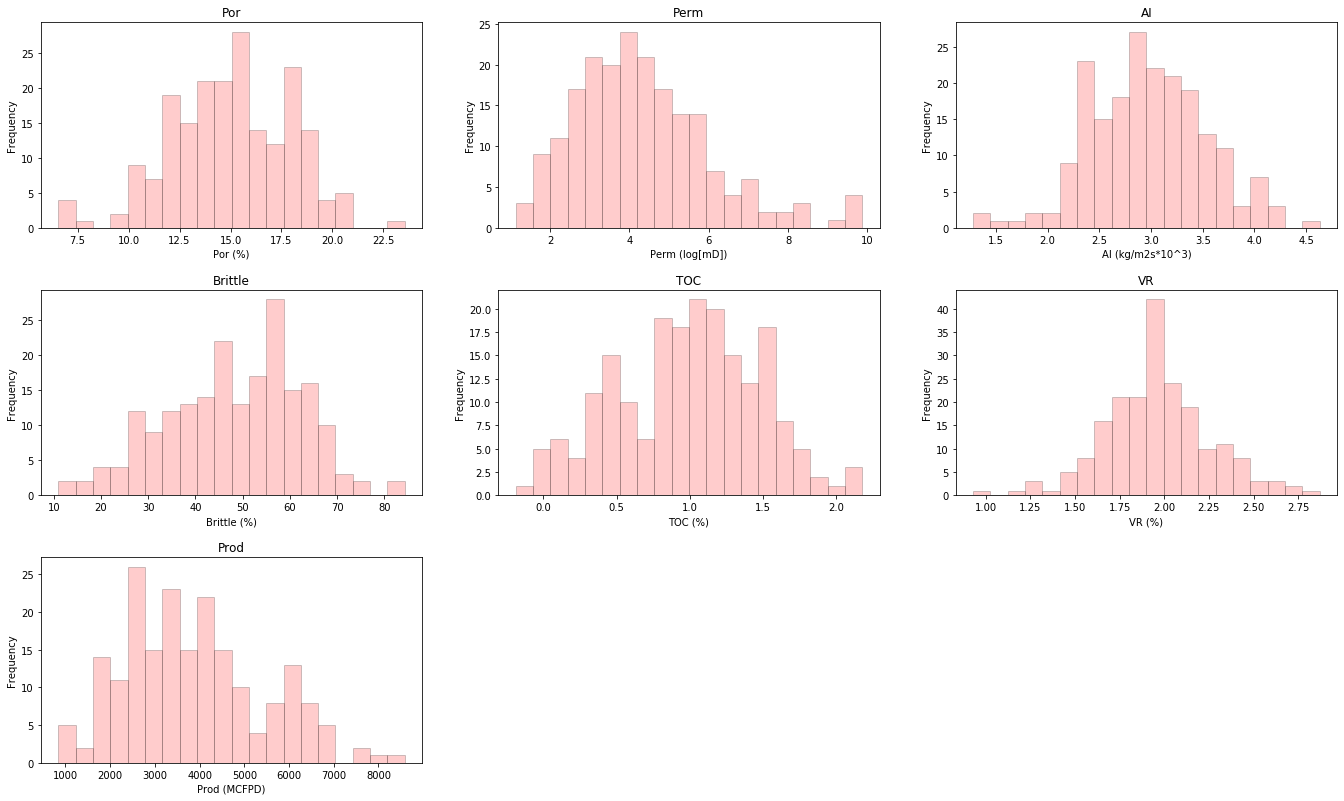

In [10]:
for i, feature in enumerate(features):

    plt.subplot(4,3,i+1)
    GSLIB.hist_st(df[feature].values,fmin[i],fmax[i],log=False,cumul = False,bins=20,weights = None,xlabel=str(feature + ' (' + units[i] + ')'),title=feature)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.3)
#plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

The univariate distributions look pretty good, although there are some potential outliers.


### Ranking Method \#3 - Bivariate Distributions

Matrix scatter plots are a very efficient method to observe the bivarate relationships between the variables.  

* this is another opportunity through data visualization to identify data issues
* we can assess if we have colinearity, specifically simpler form between two features at a time. 

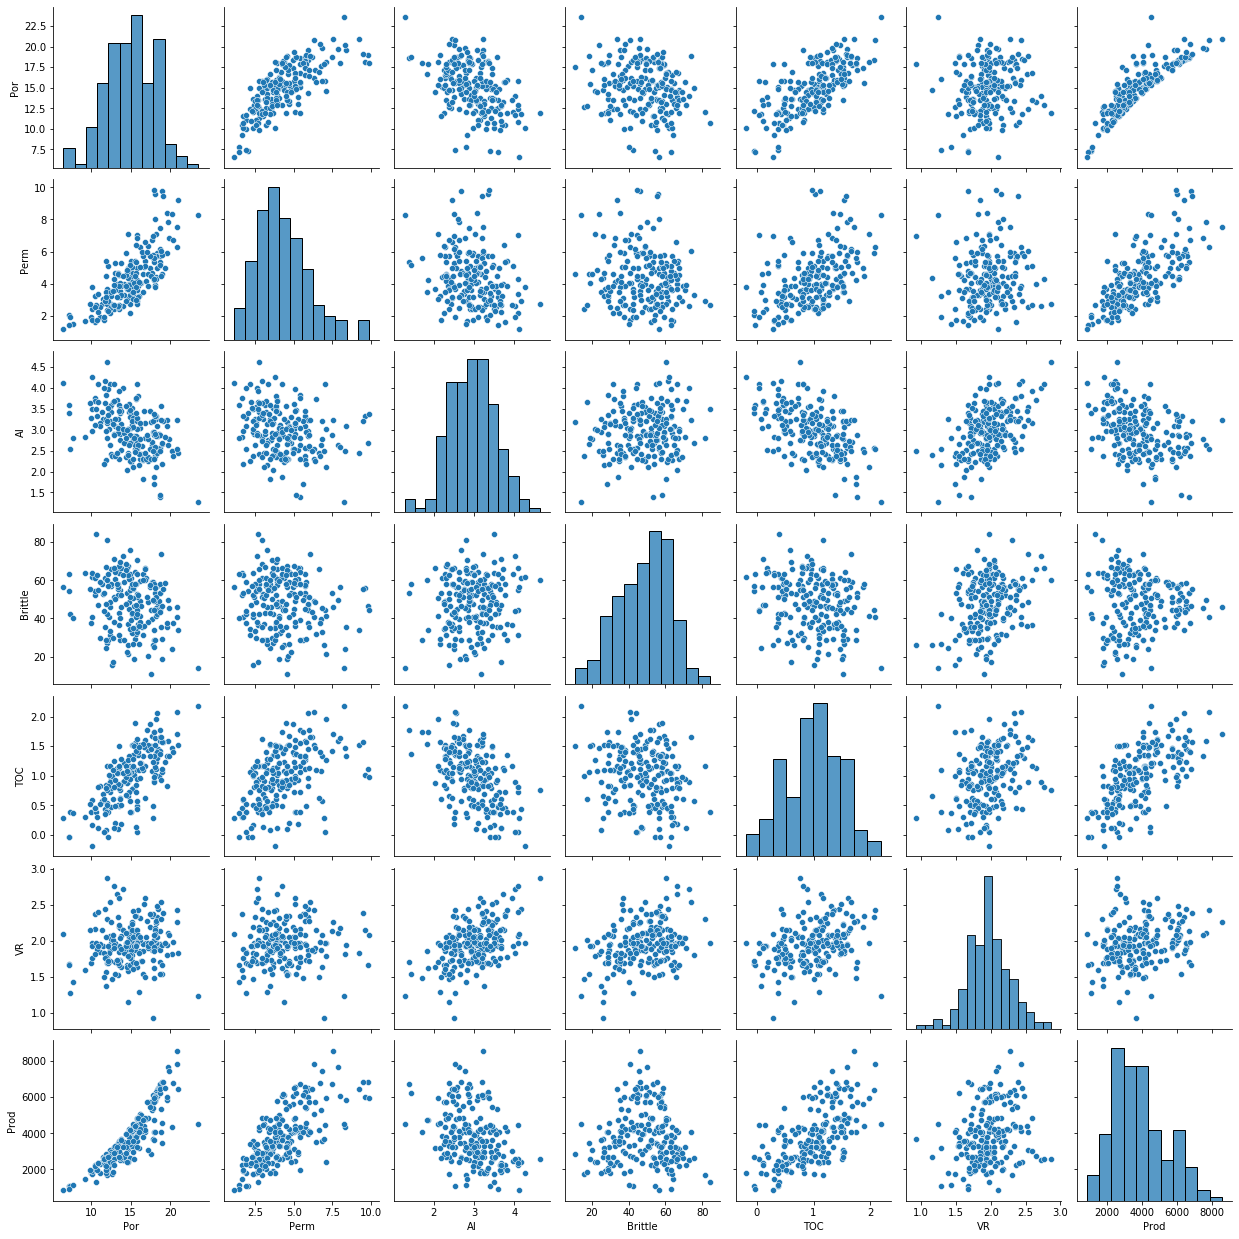

In [11]:
sns.pairplot(df,vars=features,markers='o')

This plot communicates a lot of information. How could we use this plot for variable ranking?

* we can identify variables that are closely related to eachother.  e.g. if two variables have almost a perfect monotonic linear or near linear relationship we should remove one immediately.  This is a simple case of colinearity that will likley result in model instability as discussed above.

* we can check for linear vs. non-linear relationships.  If we observe nonlinear bivariate relationships this will impact the choice of methods, and the quality of results from methods that assume linear relationships for variable ranking.

* we can identify constraint relationships and heteroscedasticity between variables. Once again these may restrict our ranking methods and also encourage us to retains specific features to retain these features in the resulting model. 

Yet, we must remember that bivariate visualization and analysis is not sufficient to understand all the multivariate relationships in the data. Multicollinearity includes strong linear relationships between 2 or more features. These may be hard to see with only bivariate plots.

### Ranking Method \#4 - Pairwise Covariance

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature. At this point, we specify that the goal of this study is to predict production, our response variable, from the other available predictor features.  We are thinking predictively now, not inferentially, we want to estimate the function, $\hat{f}$, to accomplish this:

\begin{equation}
Y = \hat{f}(X_1,\ldots,X_n) 
\end{equation}

where $Y$ is our response feature and $X_1,\ldots,X_n$ are our predictor features.  If we retained all of our predictor features to predict the response we would have: 

\begin{equation}
Prod = \hat{f}(Por,Perm,AI,Brittle,TOC,VR) 
\end{equation}

Now back to the covariance, the covariance is defined as:  

\begin{equation}
C_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}
\end{equation}

Covariance:
* measures the linear relationship
* sensitive to the dispersion / variance of both the predictor and response

We can use the follow command to build a covariance matrix:

```p
df.iloc[:,1:8].cov()
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the covariances between all predictors features and the response.


In [12]:
covariance = df.iloc[:,:].cov().iloc[ncol-1,:ncol-1]
print(covariance)

Por        4068.428763
Perm       1896.162708
AI         -323.362855
Brittle    -462.973464
TOC         477.516295
VR          107.848210
Name: Prod, dtype: float64


The covariance is useful, but as you can see the magnitude is quite variable. Most importantly these magnitudes are a function of each feature's variance. Feature variance is somewhat arbitrary. For example, what is the variance of porosity in fraction vs. percentage or permeaiblity in Darcy vs. milliDarcy. We can show that if we apply a constant multiplier, $c$, to a variable, $X$, that the variance will change according to this relationship (the proof is based on expectation formulation of variance):

\begin{equation}
\sigma_{cX}^2 = c^2 \cdot \sigma_{X}^2
\end{equation}

By moving from percentage to fraction we decrease the variance of porosity by a factor of 10,000! The variance of each variable is potentially arbitrary, with the exception when all the features are in the same units. 

Pairwise correlations avoids this issue. 

### Ranking Method \#5 Pairwise Correlation Coefficient

Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.  

\begin{equation}
\rho_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)\sigma_x \sigma_y}, \, -1.0 \le \rho_{xy} \le 1.0
\end{equation}

The correlation coefficient:

* measures the linear relationship
* removes the sensitiviety to the dispersion / variance of both the predictor and response features, by normalizing by the product of the standard deviation of each feature 

We can use the follow command to build a correlation matrix:

```p
df.iloc[:,1:8].corr()
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the correlations between all predictors features and the response.


In [13]:
correlation = df.iloc[:,:].corr().iloc[ncol-1,:ncol-1]
print(correlation)

Por        0.881555
Perm       0.705222
AI        -0.367237
Brittle   -0.021095
TOC        0.638357
VR         0.230806
Name: Prod, dtype: float64


This is interesting. 

* We see that porosity, permeability and total organic carbon have the strongest linear relationships with production. 
* Acoustic impedance has weak negative relationships with production.
* Brittleness is very close to 0.0. If you review the brittleness vs. production scatterplot, you'll observe a complicated non-linear relationship. There is a brittleness ratio sweetspot for production (rock that is not too soft nor too hard)!

We are still limited to a strick linear relationship.  The rank correlation allows us to relax this assumption.

### Ranking Method \#6 Pairwise Spearman Rank Correlation Coefficient

The rank correlation coefficient applies the rank transform to the data prior to calculating the correlation coefficent. To calculate the rank transform simply replace the data values with the rank $R_x = 1,\dots,n$, where $n$ is the maximum value and $1$ is the minimum value. 

\begin{equation}
\rho_{R_x R_y}  = \frac{\sum_{i=1}^{n} (R_{x_i} - \overline{R_x})(R_{y_i} - \overline{R_y})}{(n-1)\sigma_{R_x} \sigma_{R_y}}, \, -1.0 \le \rho_{xy} \le 1.0
\end{equation}

\begin{equation}
x_\alpha, \, \forall \alpha = 1,\dots, n, \, | \, x_i \ge x_j \, \forall \, i \gt j 
\end{equation}

\begin{equation}
R_{x_i} = i
\end{equation}

The rank correlation:

* measures the monotonic relationship, relaxes the linear assumption
* removes the sensitiviety to the dispersion / variance of both the predictor and response, by normalizing by the product of the standard deviation of each. 

We can use the follow command to build a rank correlation matrix and calculate the p-value:

```p
stats.spearmanr(df.iloc[:,1:8])
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with 
the correlations between all predictors features and the response.

Also, we get a very convenient *pval* 2D ndarry with the two-sided (two-tail summing semmetric over both tails) p-value for a hypothesis test with: 

\begin{equation}
H_o: \rho_{R_x R_y} = 0
\end{equation}

\begin{equation}
H_1: \rho_{R_x R_y} \ne 0
\end{equation}

Let's keep the p-values between all the predictor features and our response feature.

In [14]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,:])
rank_correlation = rank_correlation[:,ncol-1][:ncol-1]
rank_correlation_pval = rank_correlation_pval[:,ncol-1][:ncol-1]
print(rank_correlation)
print(rank_correlation_pval)

[ 0.9056479   0.70094589 -0.37968924 -0.05800131  0.65144349  0.25142017]
[1.04774522e-75 6.96211663e-31 2.93927576e-08 4.14609952e-01
 1.54824325e-25 3.29170847e-04]


There are some interesting results:

* we almost doubled the correlation between Brittleness and Production be relaxing the linear assumption, of course it is still low due to the monotonic assumption in with the rank correlation.
* we increased the correlation between porosity and production. See the slightly curve in the porosity and production constraint.
* only the brittleness vs. production rank correlation coefficient is not significantly different than zero

All of these methods up to now have considered one variable at a time. We can also consider methods that consider all features jointly to 'isolate' the influence of each feature.

### Ranking Method \#7 Partial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining variables, $\rho_{XY.Z}$ and $\rho_{YX.Z}$ is the partial correlation between $X$ and $Y$, $Y$ and $X$, after controlling for $Z$.

To calculate the partial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

1. perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the predictors to calculate the estimate, $X^*$

2. calculate the residuals in Step \#1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

3. perform linear, least-squares regression to predict $Y$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $Y$ is regressed on the predictors to calculate the estimate, $Y^*$

4. calculate the residuals in Step #3, $Y-Y^*$, where $Y^* = f(Z_{1,\ldots,m-1})$, linear regression model

5. calculate the correlation coefficient between the residuals from Steps #2 and #4, $\rho_{X-X^*,Y-Y^*}$

The partial correlation, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other features on both, $X$ and $Y$.  We use the function declared previously taken from Fabian Pedregosa-Izquierdo, f@bianp.net. The original code is on GitHub at https://git.io/fhyHB.

To use this method we must assume:

1. two variables to compare, $X$ and $Y$
2. other variables to control, $Z_{1,\ldots,m-2}$ 
3. linear relationships between all variables
4. no significant outliers
5. approximately bivariate normality between the variables

We are in pretty good shape, but we have some departures from bivariate normality.  We could consider Gaussian univariate transforms to improve this.  This option is provided later.

In [15]:
partial_correlation = partial_corr(df.iloc[:,:])
partial_correlation = partial_correlation[:,ncol-1][:ncol-1]
print(partial_correlation)

[ 0.57887881  0.33492821 -0.44942219 -0.09647938 -0.22846113  0.32974391]


Now we see a lot of new things about the unique contributions of each predictor feature! 

* porosity and permeability are strongly correlated with each other so they are penalized severely 

* acoustic impedance's and vitrinite reflectance's absolute correlation are increased reflecting their unique contributions

* total organic carbon flipped signs!  When we control for all other variables, it has a negative relationship with production. 

With the partial correlation coefficients we have controlled for the influence of all other predictor features on both the specific predictor and the response features. The semipartial correlation filters out the influence of all other predictor features on the raw response variable. 

### Ranking Method \#8 Semipartial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$.  Note: we do not control for influence of $Z$ features on the response feature, $Y$. 

To calculate the semipartial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

1. perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the remaining predictor features to calculate the estimate, $X^*$

2. calculate the residuals in Step \#1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

3. calculate the correlation coefficient between the residuals from Steps #2 and $Y$ response feature, $\rho_{X-X^*,Y}$

The semipartial correlation coefficient, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other predictor features on the predictor feature, $X$, to get the unique contribution of $X$ with respect to $Y$. We use a modified version of the partial correlation function that we declared previously. The original code is on GitHub at https://git.io/fhyHB.

In [16]:
semipartial_correlation = semipartial_corr(df.iloc[:,:])
semipartial_correlation = semipartial_correlation[:,ncol-1][:ncol-1]
print(semipartial_correlation)

[ 0.30852263  0.3347527   0.10867259  0.05479006 -0.00709498  0.42386178]


More information to consider:

* porosity, permeability and vitrinite reflectance are the most important by this feature ranking method
* all other predictor features have quite low correlations

This is a good moment to stop and take stock of all the results from the quantitative methods.  We will plot them all together.

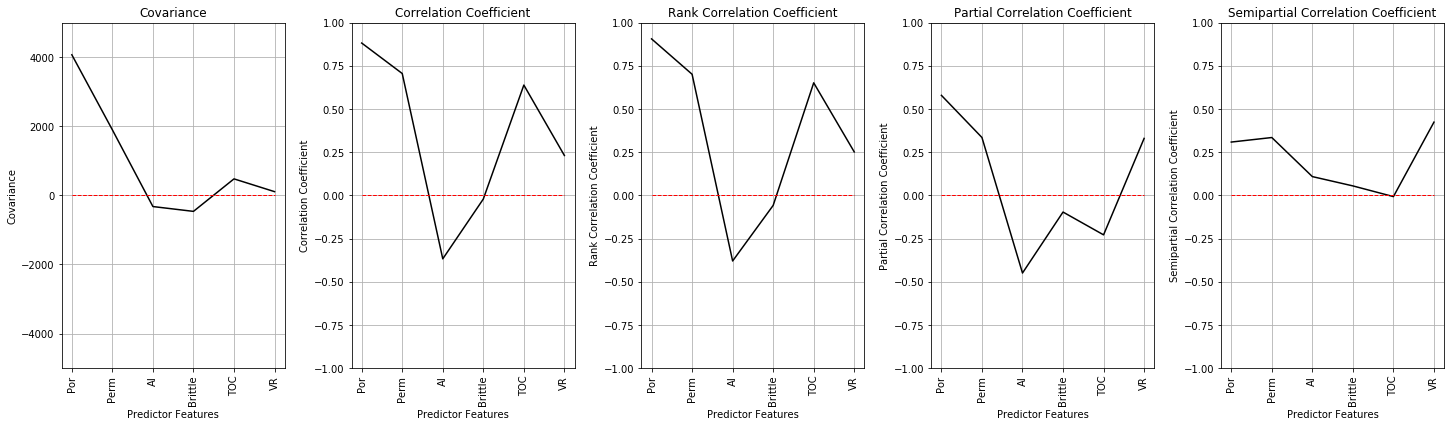

In [17]:
plt.subplot(151)
plt.plot(features[:ncol-1],covariance,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Covariance');
t = plt.title('Covariance')
plt.ylim(-5.0e3,5.0e3)
plt.grid(True)

plt.subplot(152)
plt.plot(features[:ncol-1],correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features[:ncol-1],rank_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features[:ncol-1],partial_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features[:ncol-1],semipartial_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

I think we are converging on porosity, permeability and vitrinite reflectance as the most important variables with respect to linear relationships with the production.  

### Repeat with Standardization or Normal Score Transform of All Features

Just as a check, let's standardize all the features and repeat the previously calculated quantitative methods. We know this will have an impact on covariance, what about the partial and semipartial correlations?

There is a bunch of code to get this done, but it isn't too complicated. First, lets make a new DataFrame with all variables standardized. Then we can make a minor edit (change the DataFrame name) and reuse the code from above. You can choose between:

1. Afine Correction - scale the distributions to have $\overline{x} = 0$ and $\sigma_x = 1.0$.
2. Normal Score Transform - distribution transform of each feature to standard normal, Gaussian shape with $\overline{x} = 0$ and $\sigma_x = 1.0$.

Use this block to perform affine correction of the features:

In [18]:
# dfS = pd.DataFrame()
# dfS['Well'] = df['Well'].values
# dfS['Por'] = GSLIB.affine(df['Por'].values,0.0,1.0)
# dfS['Perm'] = GSLIB.affine(df['Perm'].values,0.0,1.0)
# dfS['AI'] = GSLIB.affine(df['AI'].values,0.0,1.0)
# dfS['Brittle'] = GSLIB.affine(df['Brittle'].values,0.0,1.0)
# dfS['TOC'] = GSLIB.affine(df['TOC'].values,0.0,1.0)
# dfS['VR'] = GSLIB.affine(df['VR'].values,0.0,1.0)
# dfS['Prod'] = GSLIB.affine(df['Prod'].values,0.0,1.0)
# dfS.head()

Use this block to perform normal score transform of the features:

In [19]:
dfS = pd.DataFrame()

for i, feature in enumerate(features):
    dfS['N' + feature] = geostats.nscore(df,feature)[0]

dfS.head(n=7)

,NPor,NPerm,NAI,NBrittle,NTOC,NVR,NProd
0,-0.964092,-0.780664,-0.285841,2.432379,0.312053,1.114651,-1.780464
1,-0.832725,-0.378580,0.446827,-0.195502,-0.272809,-0.325239,-0.392079
2,-0.312053,-1.069155,1.722384,2.004654,-0.272809,2.241403,-0.832725
3,0.730638,1.325516,-0.531604,-0.590284,0.131980,-0.325239,0.815126
4,0.698283,0.298921,0.365149,-2.870033,1.047216,-0.259823,-0.531604
5,-0.208293,0.419296,-0.433020,0.259823,-0.157311,-1.069155,0.170013
6,-0.502949,-0.325239,-0.031338,1.162580,-0.446827,-0.446827,-0.446827


Regardless of transform that you chose it it good to check the summary statistics.  

In [20]:
dfS.describe()

,NPor,NPerm,NAI,NBrittle,NTOC,NVR,NProd
count,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,2.000000e+02
mean,-0.009700,0.010306,9.732356e-03,8.028717e-05,0.014152,0.017360,1.617223e-03
std,1.040456,1.005488,1.000221e+00,1.000278e+00,0.989223,1.000401,9.949811e-01
min,-4.991462,-3.355431,-2.782502e+00,-2.870033e+00,-2.336891,-2.899210,-2.483589e+00
25%,-0.670577,-0.647337,-6.588985e-01,-6.705770e-01,-0.670577,-0.651072,-6.705770e-01
50%,0.006267,0.006267,8.881784e-16,8.881784e-16,0.018807,0.006267,8.881784e-16
75%,0.670577,0.678574,6.705770e-01,6.705770e-01,0.682378,0.682642,6.705770e-01
max,2.807034,2.807034,2.807034e+00,2.807034e+00,2.807034,2.807034,2.807034e+00


We should also check the matrix scatter plot again.

* If you performed normal score transform, you have standardized the mean and variance and correct the univariate shape of the distribution, but the bivariate relationships still depart from Gaussian.

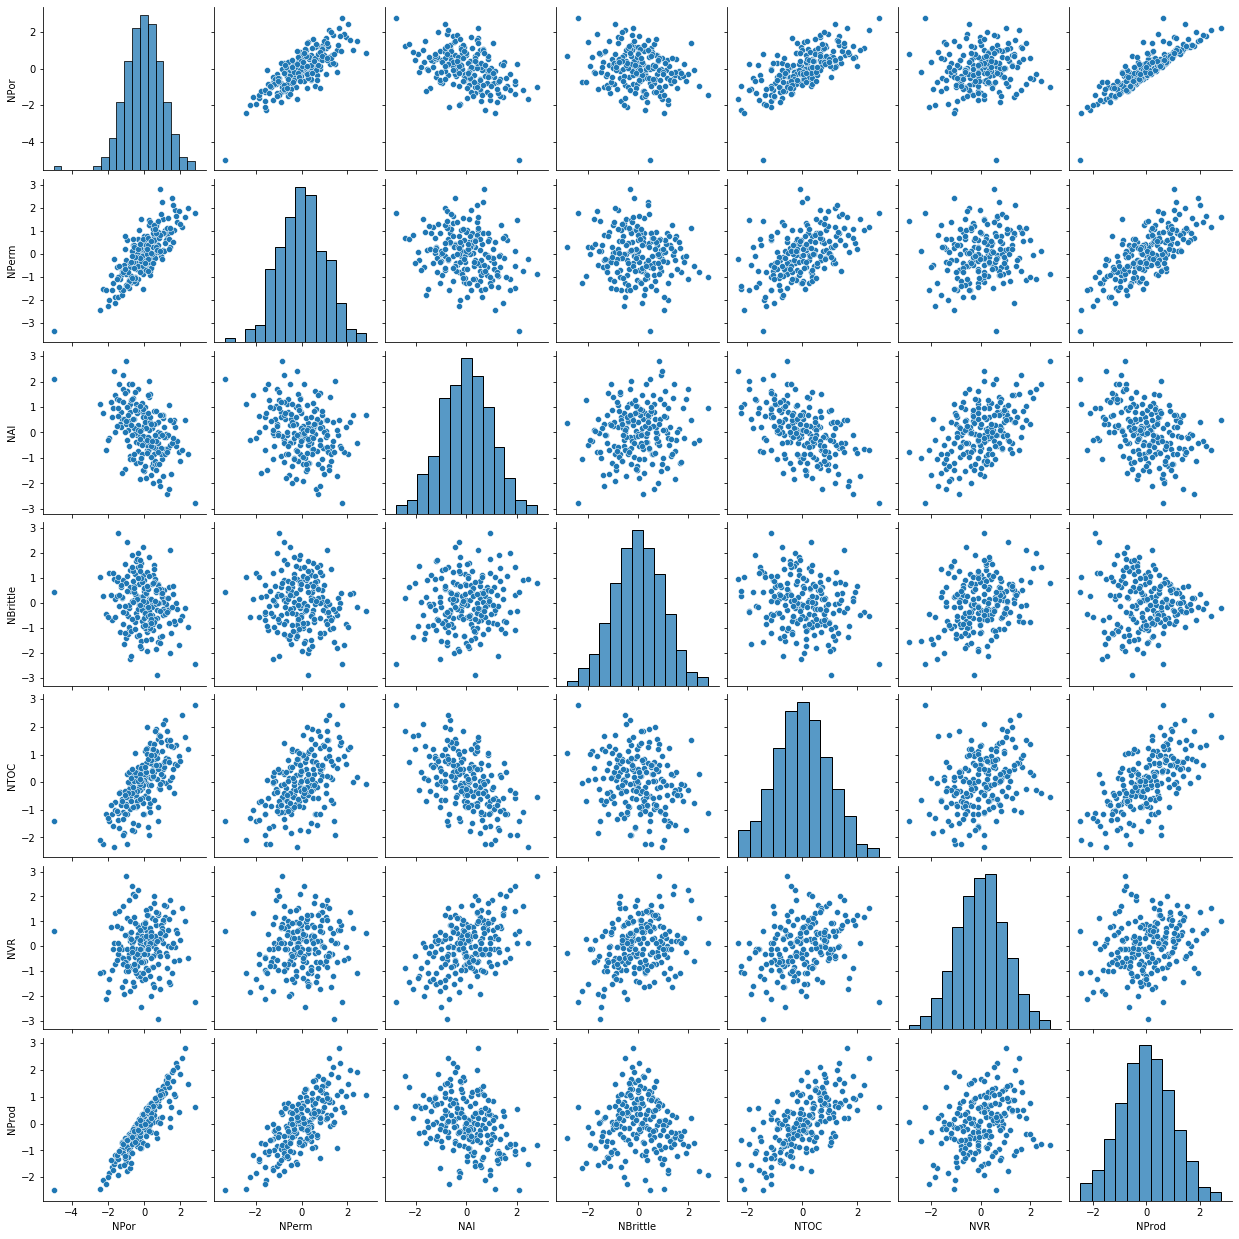

In [21]:
sns.pairplot(dfS,vars=dfS.columns,markers='o');

This is the new DataFrame with standardized variables. Now we repeat the previous calculations.

In [22]:
Ncovariance = dfS.iloc[:,:].cov().iloc[ncol-1,:ncol-1]
Ncorrelation = dfS.iloc[:,:].corr().iloc[ncol-1,:ncol-1]
Nrank_correlation, Nrank_correlation_pval = stats.spearmanr(dfS.iloc[:,:])
Nrank_correlation = Nrank_correlation[:,ncol-1][:ncol-1]
Nrank_correlation_pval = Nrank_correlation_pval[:,ncol-1][:ncol-1]
Npartial_correlation = partial_corr(df.iloc[:,:])
Npartial_correlation = Npartial_correlation[:,ncol-1][:ncol-1]
Nsemipartial_correlation = semipartial_corr(df.iloc[:,:])
Nsemipartial_correlation = Nsemipartial_correlation[:,ncol-1][:ncol-1]

and repeat the previous summary plot.

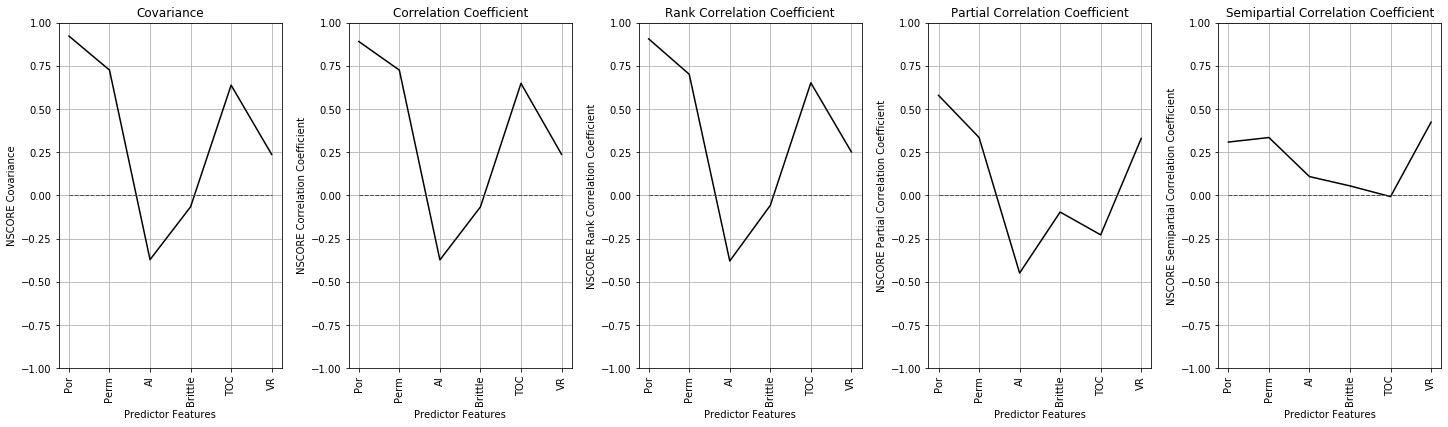

In [23]:
plt.subplot(151)
plt.plot(features[:ncol-1],Ncovariance,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('NSCORE Covariance');
t = plt.title('Covariance')
plt.ylim(-1.0,1.0)
plt.grid(True)

plt.subplot(152)
plt.plot(features[:ncol-1],Ncorrelation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('NSCORE Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features[:ncol-1],Nrank_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('NSCORE Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features[:ncol-1],Npartial_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('NSCORE Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features[:ncol-1],Nsemipartial_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('NSCORE Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

What should you observe:

* covariance is now equal to correlation coefficient
* the semipartial correlations are sensitive to the feature standardization (affine correlation or normal score transform).


### Model-based Feature Ranking 

With these methods we evaluate the performance of the features in building an actual predictive model. Let's start with $B$ coefficients.

### Ranking Method \#9 $B$ Coefficients / Beta Weights 

We could also consider $B$ coefficients.  These are the linear regression coefficients without standardization of the variables. Let's use the linear regression method that is available in the SciPy package.

The estimator for $Y$ is simply the linear equation:

\begin{equation}
Y^* = \sum_{i=1}^{m} b_i X_i + c
\end{equation}

The $b_i$ coefficients are solved to minimize the squared error between the estimates, $Y^*$ and the values in the training dataset, $Y$.

In [24]:
df['const'] = np.ones(len(df))                  # let's add one for the constant term
b = linalg.lstsq(df.iloc[:,:ncol-1],df.iloc[:,[ncol-1]])[0]
df = df.drop('const',axis = 1)
print(b[0:ncol-1])

[[  270.01096791]
 [  231.30297484]
 [-1365.2584841 ]
 [   -6.36976742]
 [ -913.63465728]
 [ 2089.90482773]]


The ouput is the $b$ coefficients, ordered over our features from $b_i, i = 1,\ldots,n$ and then the intercept, $c$, that I have removed to avoid confusion.

* we see the negative contribution of AI and TOC
* the results are very sensitive to the magnitudes of the variances of the predictor features. 

We can remove this sensitivity by working with standardized features.

### Ranking Method \#10 $\beta$ Coefficients / Beta Weights 

$\beta$ coefficients are calculated as the linear regression of the coefficients after we have standardized the predictor and response features to have a variance of one.  

\begin{equation}
\sigma^2_{X^s_i} = 1.0 \quad \forall \quad i = 1,\ldots,m, \quad \sigma^2_{Y^s} = 1.0
\end{equation}

The estimator for $Y^s$ standardized is simply the linear equation:

\begin{equation}
Y^{s*} = \sum_{i=1}^{m} \beta_i X^s_i + c
\end{equation}

It is convenient that we have just standardized all our variables to have a variance of 1.0 just recently (see above). Let's use the same linear regression method again on the standardized features to get $\beta$ coefficients. 

In [25]:
dfS['const'] = np.ones(len(df))                  # let's add one for the constant term
beta = linalg.lstsq(dfS.iloc[:,:ncol-1],dfS.iloc[:,[ncol-1]])[0]
dfS = dfS.drop('const',axis = 1)
print(beta[0:ncol-1])

[[ 0.77773852]
 [ 0.07152428]
 [-0.16012656]
 [ 0.05086478]
 [-0.09785779]
 [ 0.23565726]]


Some observations:

* the change between $b$ and $\beta$ coefficients is not just a constant scaling

* porosity, acoustic impedance and total organic carbon have the great weight in the estimate of production

There is more we can do with model-based methods. We will actually test models to assess the incremental impact of each predictor feature! We will try this with recursive feature elimination.

Let's plot the results from the $B$ and $\beta$ coefficients and compare with the previous results.


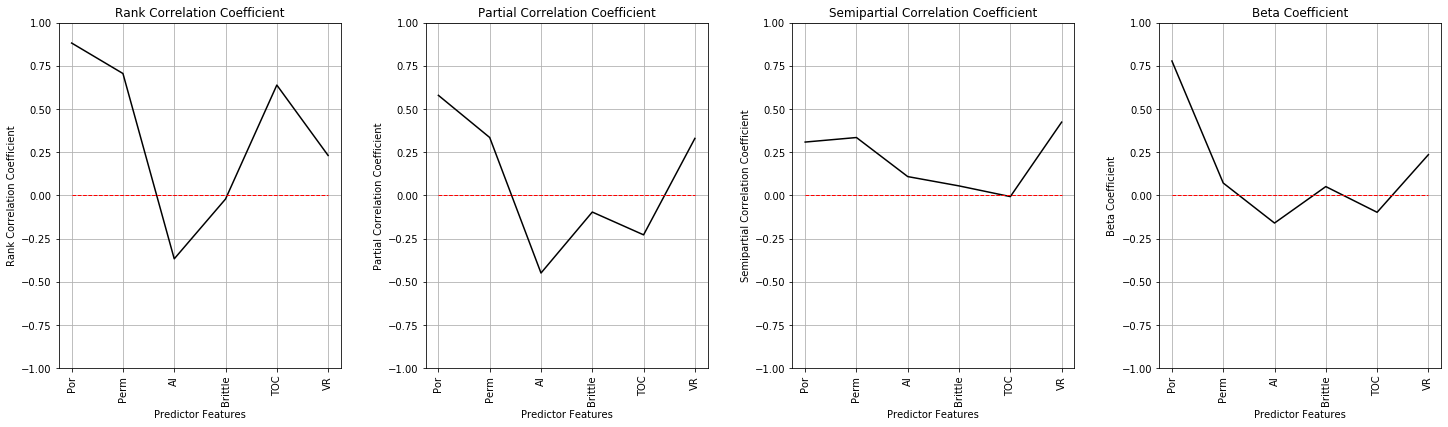

In [26]:
plt.subplot(141)
plt.plot(features[:ncol-1],correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(142)
plt.plot(features[:ncol-1],partial_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(143)
plt.plot(features[:ncol-1],semipartial_correlation,color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)


plt.subplot(144)
plt.plot(features[:ncol-1],beta[0:ncol-1],color='black')
plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Beta Coefficient')
t = plt.title('Beta Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

We have a wide array of criteria to rank our features.  

* the $\beta$ coefficients remove this sensitivity and are consistent with previous results.

Given all of these methods, I would rank the top features as:

1. Porosity
2. Vitrinite Reflectance
3. Permeability
4. Acoustic Impedance

I have assigned these ranks by observing the general trend in these matrics.  Of course, we could make a more quantitative score and rank by weighting each method.

As mentioned before, we should not neglect expert knowledge. If additional information is known about physical processes, causation, and reliability and availability of variables this should be integrated into assigning ranks.

We include a bonus method here, recursive feature elimination, but only provide a simple linear regression model example. More could be done with more complicated models.

### Ranking Method \#11 Mutual Information

Mutual information is a generalized approach that quantifies the mutual dependence between two features.  

* quantifies the amount of information gained from observing one feature about the other

* avoids any assumption about the form of the relationship (e.g. no assumption of linear relationship)

* compares the joint probabilities to the product of the marginal probabilities

For discrete or binned continuous features $X$ and $Y$, mutual information is calculated as:

\begin{equation}
I(X;Y) = \sum_{y \in Y} \sum_{x \in X}P_{X,Y}(x,y) log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right)
\end{equation}

recall for indepedence:

\begin{equation}
P_{X,Y}(x,y) = P_X(x) \cdot P_Y(y)
\end{equation}

therefore if the two features are independent then the $log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right) = 0$

The joint probability $P_{X,Y}(x,y)$ is a weighting term on the sum and enforces closure.

* parts of the joint distribution with greater density have greater impact on the mutual information metric

For continuous (and nonbinned) features we can applied the integral form.

\begin{equation}
I(X;Y) = \int_{Y} \int_{X}P_{X,Y}(x,y) log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right) dx dy
\end{equation}

We get a sorted list of the indices in decreasing order of importance with the command

```python
indices = np.argsort(importances)[::-1]
```

the slice reverses the order, for descending order of importance.

Feature ranking:
1. feature Por = 1.000000
2. feature Perm = 0.345919
3. feature TOC = 0.274068
4. feature Brittle = 0.073557
5. feature AI = 0.052581
6. feature VR = 0.008426


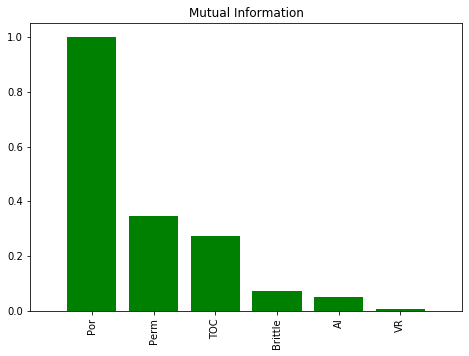

In [27]:
from sklearn.feature_selection import mutual_info_regression

X = df.iloc[:,:ncol-1]                   # separate DataFrames for predictor and response features
y = df.iloc[:,[ncol-1]]

mi = mutual_info_regression(X,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(X.shape[1]):
    print("%d. feature %s = %f" % (f + 1, X.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(X.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()


### Ranking Method \#12 - Feature Importance

A variety of machine learning methods provide measures of feature importance.  

* for example decision trees track the reduction in mean square error through inclusion of each feature

Let's look at the feature importance from a random forest regressor fit to our data.

* We will instantiate a random forest with default hyperparameters. This results in unlimited complexity, over-trained trees in our forest. The averaging of these trees takes care of the overfit issue.

* Then we will train our random forest and extract the importances (expectation over all the trees)

* we can also extract the feature importances over all the trees in the forest and summarize with the standard deviation to access the robustness of our feature importance measure

Mean Squared Error on Training =  44362.08 , Variance Explained = 0.98
Feature ranking:
1. feature 0 (0.321845)
2. feature 1 (0.199560)
3. feature 4 (0.174676)
4. feature 3 (0.115550)
5. feature 2 (0.100505)
6. feature 5 (0.087865)


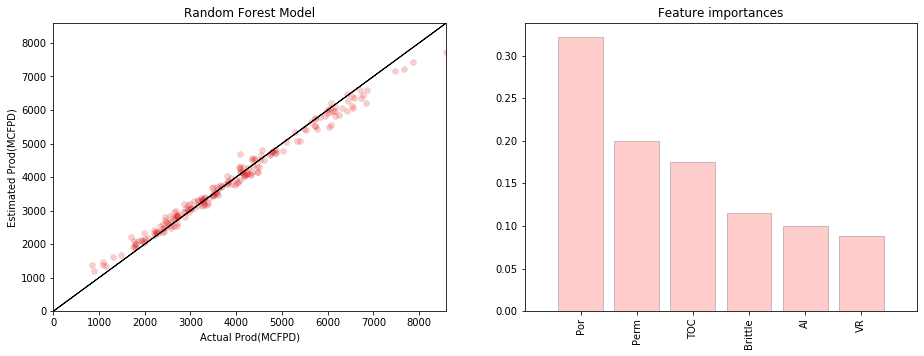

In [28]:
X = df.iloc[:,:ncol-1]                   # separate DataFrames for predictor and response features
y = df.iloc[:,[ncol-1]]

seed = 73093                                                # set the random forest hyperparameters
# # #Underfit random forest
# max_leaf_nodes = 2
# num_tree = 10
# max_features = 0.2

# #Overfit random forest
# max_leaf_nodes = 50
# num_tree = 1
# max_features = 0.6

# #Good random forest
max_leaf_nodes = 200
num_tree = 300
max_features = 0.3

random_forest = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=seed,n_estimators=num_tree, max_features=max_features)
random_forest.fit(X = X, y = y.values.reshape(-1,))

y_hat = predict_train = random_forest.predict(X)

MSE = metrics.mean_squared_error(y,y_hat)
Var_Explained = metrics.explained_variance_score(y,y_hat)
print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))

importances = random_forest.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([random_forest.feature_importances_ for tree in random_forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

plt.subplot(121)
plt.scatter(y,y_hat,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Random Forest Model'); plt.xlabel('Actual ' + features[ncol-1] + '(' + units[ncol-1] +')'); plt.ylabel('Estimated ' + features[ncol-1] + '(' + units[ncol-1] +')')
plt.xlim(0,fmax[ncol-1]); plt.ylim(0,fmax[ncol-1])
plt.arrow(0,0,fmax[ncol-1],fmax[ncol-1],width=0.02,color='black',head_length=0.0,head_width=0.0)

importance_rank = random_forest.feature_importances_/np.max(random_forest.feature_importances_)

print("Feature ranking:")                 # write out the feature importances
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(122)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.2)
plt.show()

### Ranking Method \#13 Recursive Feature Elimination 

Recursive Feature Elimination (RFE) method works by recursively removing features and building a model with the remaining features.

* model accuracy is applied to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute

In this code we make a prediction model based on multilinear regression and indicate that we want to find the best feature based on recursive feature elimination. The algorithm assigns rank $1,\ldots,m$ for all features.

In [29]:
rfe = RFE(LinearRegression(), 1,verbose=0)      # set up RFE linear regression model
dfS['const'] = np.ones(len(dfS))                  # let's add one's for the constant term

rfe = rfe.fit(dfS.iloc[:,:ncol-1].values,np.ravel(dfS.iloc[:,[ncol-1]])) # recursive elimination

dfS = dfS.drop('const',axis = 1)                 # remove the ones

rank = rfe.ranking_
rfeatures = features
rank, rfeatures = zip(*sorted(zip(rank,rfeatures)))
print('The linear regression RFE features in rank order are ' + str(rfeatures) + '.')

The linear regression RFE features in rank order are ('Por', 'VR', 'AI', 'TOC', 'Perm', 'Brittle').


Given the nonlinear structure in the data, we need a modeling method that integrates nonlinear information.

In [30]:
rfe_forest = RFE(random_forest,n_features_to_select = 1, verbose=0)             # instantiate with the previous model
dfS['const'] = np.ones(len(dfS))            # let's add one's for the constant term

rfe_forest.fit(df.iloc[:,:ncol-1].values,np.ravel(df.iloc[:,[ncol-1]])) # recursive elimination

rrank = rfe_forest.ranking_
rfeatures = features
rrank, rfeatures = zip(*sorted(zip(rrank,rfeatures)))
print('The random forest regression RFE features in rank order are ' + str(rfeatures) + '.')

print()

rfe_rank = ((ncol - 1) - rfe_forest.ranking_)/(ncol-1)
print('Feature RFE rank scores' + str(rfe_rank))

The random forest regression RFE features in rank order are ('Por', 'Perm', 'TOC', 'Brittle', 'AI', 'VR').

Feature RFE rank scores[0.83333333 0.66666667 0.16666667 0.33333333 0.5        0.        ]


A couple of the features moved from our previous assessment, but we are close. The advantages with the recursive elimination method:

* the actual model can be used in assessing feature ranks
* the ranking is based on accuracy of the estimate

but this method is sensitive to:

* choice of model
* training dataset

This method may be applied with cross validation (k fold iteration of training and testing datasets).  

### Wide Array Feature Ranking Display

We will retain the following features:

* rank correalation - correlation while relaxing impact of outliers and monotonic nonlinearity

* partial correlation - correlation accounting for interactions 

* mutual information - shared information without accounting for interactions

* feature importance - from a random forest model

* recursive feature importance - from interative feature removal for the random forest model

We will use absolute values for correlations to aid comparison and use normalization to calculate a score for the recursive feature ranking method.

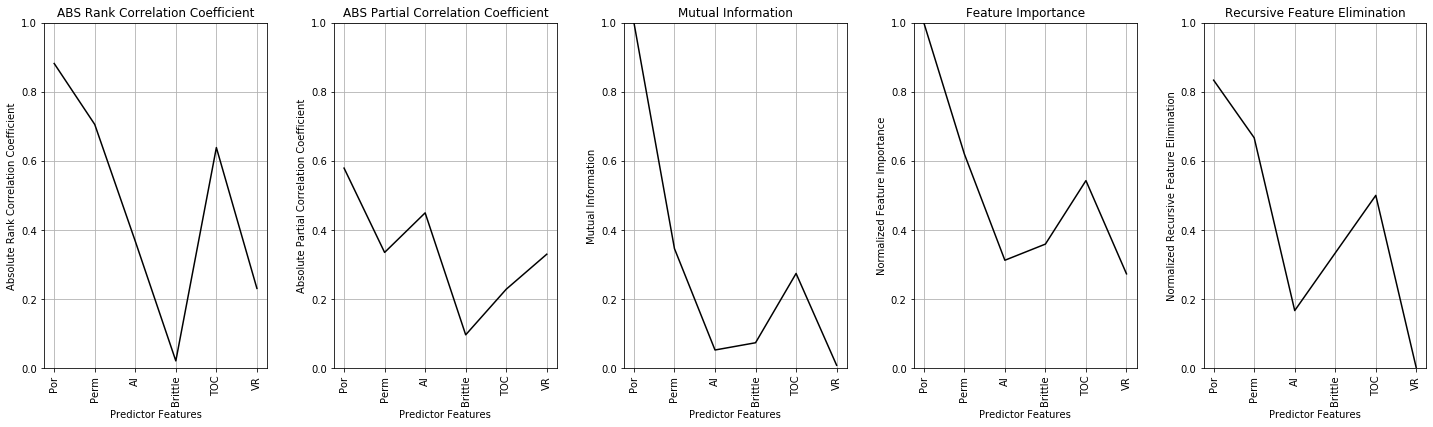

In [31]:
plt.subplot(151)
plt.plot(features[:ncol-1],np.abs(correlation),color='black')
#plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Absolute Rank Correlation Coefficient')
t = plt.title('ABS Rank Correlation Coefficient')
plt.ylim(0,1.0)
plt.grid(True)

plt.subplot(152)
plt.plot(features[:ncol-1],np.abs(partial_correlation),color='black')
#plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Absolute Partial Correlation Coefficient')
t = plt.title('ABS Partial Correlation Coefficient')
plt.ylim(0,01.0)
plt.grid(True)

plt.subplot(153)
plt.plot(features[:ncol-1],mi,color='black')
#lt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Mutual Information')
t = plt.title('Mutual Information')
plt.ylim(0.0,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features[:ncol-1],importance_rank,color='black')
#plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Normalized Feature Importance')
t = plt.title('Feature Importance')
plt.ylim(0.0,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features[:ncol-1],rfe_rank,color='black')
#plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Normalized Recursive Feature Elimination')
t = plt.title('Recursive Feature Elimination')
plt.ylim(0,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

### Unified Wide Array Feature Ranking Display

Let's combine the folloiwng metrics on a single plot

* we normalize all scores to have a minimum of 0.0 and maximum of 1.0

We use tranparency and alpha of lines to integrate the following concepts:

* grouping of metrics, correlation and feature importance based

* demote metrics that do not account for feature interactions by adding transparency

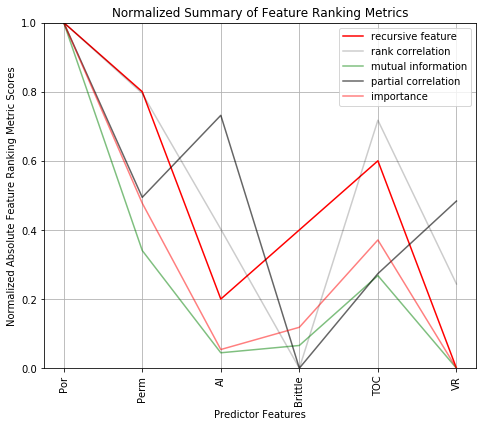

In [32]:
Nrfe = (rfe_rank - np.min(rfe_rank))/(np.max(rfe_rank) - np.min(rfe_rank))
Ncorrelation = (np.abs(correlation) - np.min(np.abs(correlation)))/(np.max(np.abs(correlation)) - np.min(np.abs(correlation)))
Nimportance = (importance_rank - np.min(importance_rank))/(np.max(np.abs(importance_rank)) - np.min(np.abs(importance_rank)))
Nmi = (mi - np.min(mi))/(np.max(mi) - np.min(mi))
Npartial_correlation = (np.abs(partial_correlation) - np.min(np.abs(partial_correlation)))/(np.max(np.abs(partial_correlation)) - np.min(np.abs(partial_correlation)))

plt.subplot(111)
plt.plot(features[:ncol-1],Nrfe,color='red',label='recursive feature')
plt.plot(features[:ncol-1],Ncorrelation,color='black',alpha=0.2,label='rank correlation')
plt.plot(features[:ncol-1],Nmi,color='green',alpha = 0.5,label='mutual information')
plt.plot(features[:ncol-1],Npartial_correlation,color='black',alpha = 0.6,label='partial correlation')
plt.plot(features[:ncol-1],Nimportance,color='red',alpha=0.5,label='importance')
#plt.plot(np.zeros(ncol-1),'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Normalized Absolute Feature Ranking Metric Scores')
t = plt.title('Normalized Summary of Feature Ranking Metrics')
plt.ylim(0,1)
plt.grid(True)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

From the above plot we can access a reasonable set of top features for predicting EUR

1. Proppant

2. Pore Pressure

3. Number of Argillic Beds

4. Mixed Bed Thickness 

### Accounting for Uncertainty 

We should also account for uncertainty to assist with interpretation. 

* we demonstrated this for a sigle metric here, muutal information

The workflow is based on bootstrap.

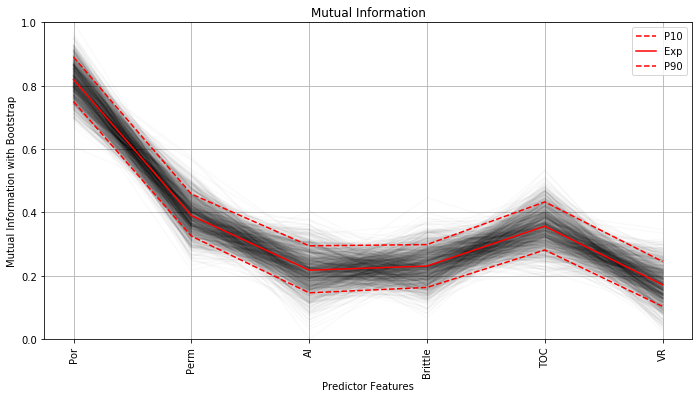

In [33]:
L = 1000

mi_mat = np.zeros([L,ncol-1])

plt.subplot(111)

for l in range(0,L):
    bootstrap_df = pd.DataFrame(df.iloc[np.random.randint(len(df), size=len(df)),:])
    X = bootstrap_df.iloc[:,:ncol-1]                   # separate DataFrames for predictor and response features
    y = bootstrap_df.iloc[:,[ncol-1]]

    mi = mutual_info_regression(X,np.ravel(y)) # calculate mutual information
    mi = mi - np.average(mi) + 0.5                  # recenter the mutual information measure
    #mi /= np.max(mi)                          # calculate relative mutual information
    mi_mat[l,:] = mi

mi_mat = (mi_mat - np.min(mi_mat.flatten()))/(np.max(mi_mat.flatten()) - np.min(mi_mat.flatten())) 

for l in range(0,L):    
    plt.plot(features[:ncol-1],mi_mat[l,:],color='black',alpha = 0.02)
    
plt.plot(features[:ncol-1],np.percentile(mi_mat,10.0,axis = 0),'--',color='red',alpha = 1.0,label='P10')
plt.plot(features[:ncol-1],np.average(mi_mat,axis = 0),color='red',alpha = 1.0,label='Exp')
plt.plot(features[:ncol-1],np.percentile(mi_mat,90.0,axis = 0),'--',color='red',alpha = 1.0,label='P90')

plt.xlabel('Predictor Features'); plt.xticks(rotation=90)
plt.ylabel('Mutual Information with Bootstrap')
t = plt.title('Mutual Information')
plt.ylim(0.0,1)
plt.grid(True)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.1, wspace=0.3, hspace=0.2)
plt.show()

### Ranking Method \#14 - Shapley Values

Let's use Shapley Values to assess model-based feature importance measures. 

* We will use all of the data values for this demonstration, all data assigned to background.

* We are not demonstrating train and test workflows at this point

* We will use the Random Forest model that we just built

Let's first check out model

Mean Squared Error on Training =  23195.15 , Variance Explained = 0.99
Feature ranking:
1. feature 0 (0.303525)
2. feature 1 (0.207409)
3. feature 4 (0.169877)
4. feature 3 (0.117559)
5. feature 5 (0.104702)
6. feature 2 (0.096928)


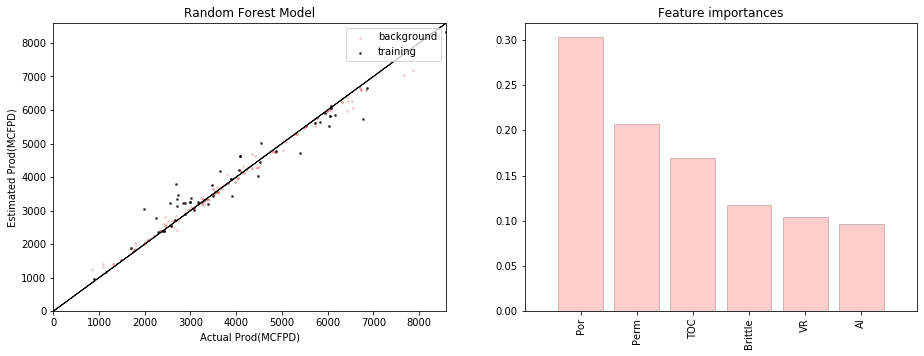

In [34]:
seed = 73093                                                # set the random forest hyperparameters
# # #Underfit random forest
# max_leaf_nodes = 2
# num_tree = 10
# max_features = 0.2

# #Overfit random forest
# max_leaf_nodes = 50
# num_tree = 1
# max_features = 0.6

# #Good random forest
max_leaf_nodes = 200
num_tree = 300
max_features = 0.3

random_forest = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=seed,n_estimators=num_tree, max_features=max_features)
random_forest.fit(X = X, y = y.values.reshape(-1,))

y_hat = predict_train = random_forest.predict(X)

MSE = metrics.mean_squared_error(y,y_hat)
Var_Explained = metrics.explained_variance_score(y,y_hat)
print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))

importances = random_forest.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([random_forest.feature_importances_ for tree in random_forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

importance_rank = random_forest.feature_importances_/np.max(random_forest.feature_importances_)

print("Feature ranking:")                 # write out the feature importances
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(122)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])

background = shap.sample(df.iloc[:,:ncol],nsamples=50,random_state=73073) # extract a limited subset for efficient Shapley calcuation and display
y_hat_background = random_forest.predict(background.iloc[:,:ncol-1])

plt.subplot(121)
plt.scatter(y,y_hat,s=5, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black",label = 'background')
plt.scatter(background.iloc[:,ncol-1],y_hat_background,s=5, c='black',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black", label = 'training')
plt.title('Random Forest Model'); plt.xlabel('Actual ' + features[ncol-1] + '(' + units[ncol-1] +')'); plt.ylabel('Estimated ' + features[ncol-1] + '(' + units[ncol-1] +')')
plt.xlim(0,fmax[ncol-1]); plt.ylim(0,fmax[ncol-1])
plt.arrow(0,0,fmax[ncol-1],fmax[ncol-1],width=0.02,color='black',head_length=0.0,head_width=0.0)
plt.legend()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.2)

#### Global Shapley Values

Let's review the global Shapley measures.

* sorted bar chart of the arithmetic average of the absolute SHAP value over the background data

* sorted plot of the SHAP value over the background data

* plot of the SHAP value over the background data as a violin plot

Note: all of these methods are applying the global average ($E[X_i]$) for each feature to impute for those cases not including feature $i$.

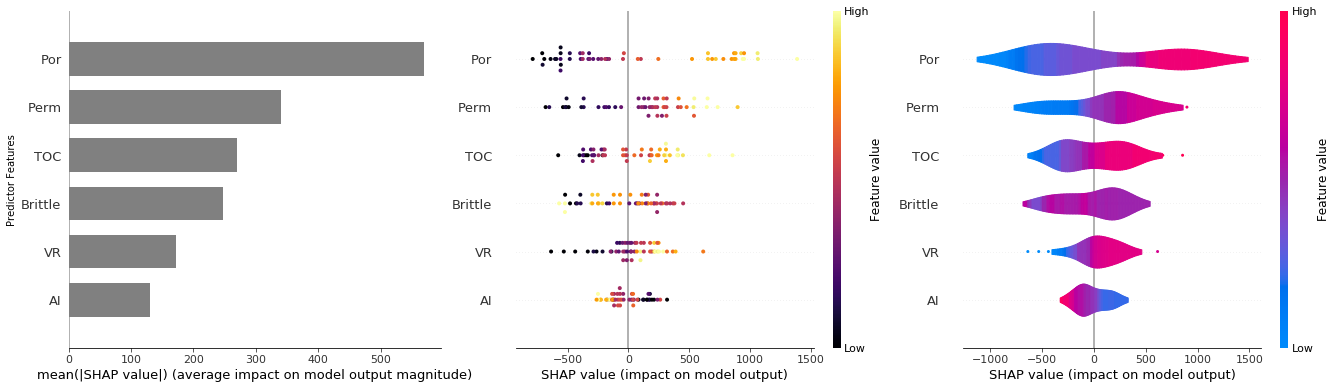

In [35]:
# global Shapley Measures
shap_values = shap.TreeExplainer(random_forest).shap_values(background.iloc[:,:ncol-1])

plt.subplot(131)
shap.summary_plot(show=False,feature_names = features[:ncol-1], shap_values = shap_values, features = background.iloc[:,:ncol-1], plot_type="bar",color = "gray", cmap = plt.cm.inferno)
plt.ylabel('Predictor Features')

plt.subplot(132)
shap.summary_plot(show=False,feature_names = features[:ncol-1], shap_values = shap_values, features = background.iloc[:,:ncol-1],cmap = plt.cm.inferno)

plt.subplot(133)
shap.summary_plot(show=False,feature_names = features[:ncol-1], shap_values = shap_values, features = background.iloc[:,:ncol-1],plot_type = "violin")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [36]:
shap_values.shape

(50, 6)

#### Local Feature Importance

Let's look at the dependency plots to observe the Shapley values for each feature ($X_i$) over the range of feature values ($x_i$).

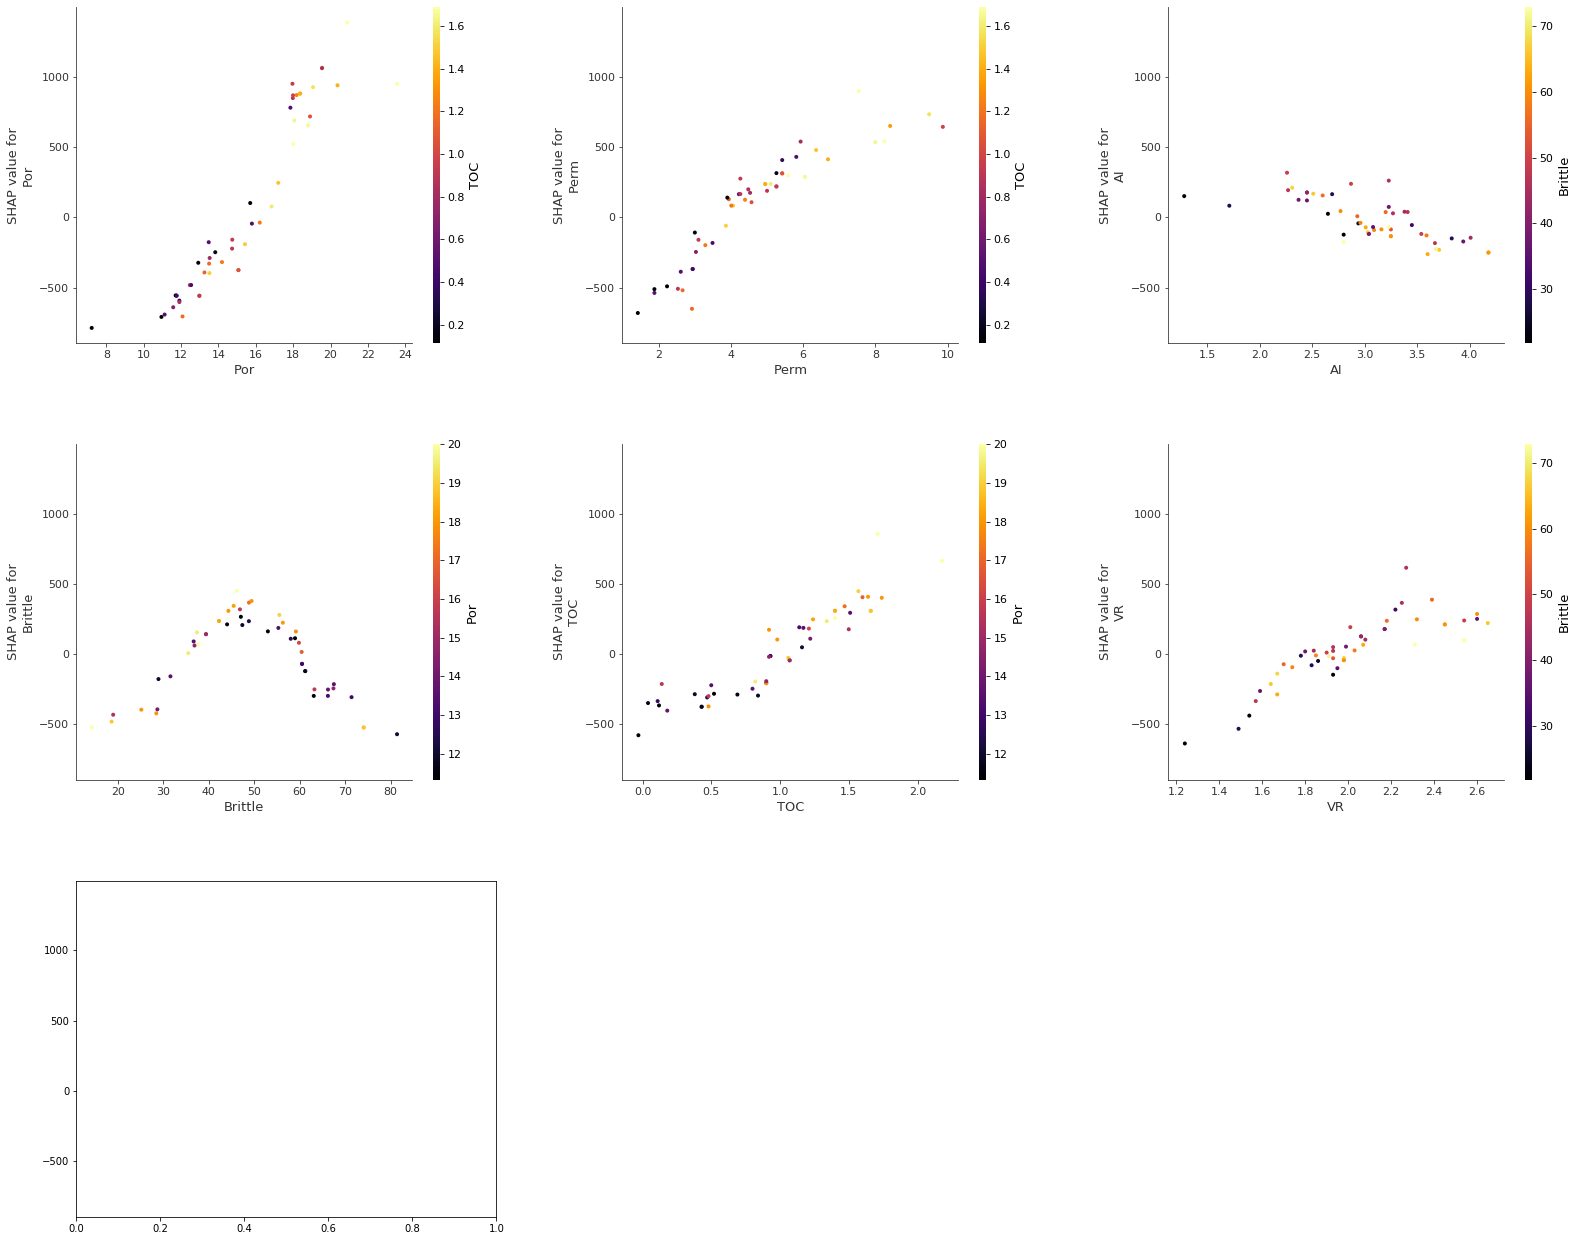

In [43]:
fig, axes = plt.subplots(3, 3, figsize=(21, 14), sharey=True)

j = 0; k = 0
for i,feature in enumerate(features[:ncol-1]):
    if k >= 3: 
        k = 0; j = j + 1
    shap.dependence_plot(ax = axes[j,k],ind = features[i],show=False,feature_names = features[:ncol-1], shap_values = shap_values, features = background.iloc[:,:ncol-1], cmap = plt.cm.inferno)
    k = k + 1
    
axes.flat[-1].set_visible(False) # to remove last 2 plots
axes.flat[-2].set_visible(False) # to remove last 2 plots
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.3)

#### Global Force Plot

We can simulaneously visualize all of the Shapley values for all of the sample data in the order of the background data set.

* blue indicates reduction in the predicted production and red indicates increase in predicted production

We are visualizing over all sample data at once and can reorder.

In [38]:
model_explainer = shap.TreeExplainer(random_forest,background.iloc[:,:ncol-1]) # Predictions using Tuned Hyperparameters compared to test data
model_shap_values = model_explainer.shap_values(background.iloc[:,:ncol-1])
shap.force_plot(model_explainer.expected_value,model_shap_values,background.iloc[:,:ncol-1],out_names = ['EUR'],feature_names=features[:ncol-1],)  

#### Local Force Plot

We pick a specific sample from the background and visualize the force plot.

* We can see the genesis of the plot above, Shapley values for all features given a local set of values in sample $i$, ($x_i$).

In [39]:
i = 10
shap.force_plot(model_explainer.expected_value,model_shap_values[i],background.iloc[i,:ncol-1],show=False,feature_names = features[:ncol-1])

#### Experimental Learning

Return to the random forest model and attempt some of these updates and observe the results.

* underfit the model, decrease the number of leaf nodes

    * smaller Shapley values are possible, marginal contribution is only meaningful for a good model!
    * disrupted order in the global feature importance violin plots
    * reduction in shapley values

* overfit the model, reduce the number of trees to 1 and increase the number of leaf nodes

    * larger Shapley values are possible
    * may have poor sampling feature importance